(ANOVA)=
# Comparing several means (one-way ANOVA)



This chapter introduces one of the most widely used tools in statistics, known as "the analysis of variance", which is usually referred to as ANOVA. The basic technique was developed by Sir Ronald Fisher in the early 20th century, and it is to him that we owe the rather unfortunate terminology. The term ANOVA is a little misleading, in two respects. Firstly, although the name of the technique refers to variances, ANOVA is concerned with investigating differences in means. Secondly, there are several different things out there that are all referred to as ANOVAs, some of which have only a very tenuous connection to one another. Third (and this is Ethan speaking now) _everything_ in statistics is an analysis of variance: analyzing variance is the entire purpose of statistics, so it seems a little unfair to give that name to any particular test. I challenge you to show me any statistical procedure that is not, in some sense, an analysis of variance. Still, Fisher got there first, so what can you do? Later on in the book we'll encounter a range of different ANOVA methods that apply in quite different situations, but for the purposes of this chapter we'll only consider the simplest form of ANOVA, in which we have several different groups of observations, and we're interested in finding out whether those groups differ in terms of some outcome variable of interest. This is the question that is addressed by a **_one-way ANOVA_**. 

The structure of this chapter is as follows: In [](anxifree) I'll introduce a fictitious data set that we'll use as a running example throughout the chapter. After introducing the data, I'll describe the mechanics of [how a one-way ANOVA actually works](anovaintro) and then focus on [how you can run one in Python](introduceaov). These two sections are the core of the chapter. The remainder of the chapter discusses a range of important topics that inevitably arise when running an ANOVA, namely [how to calculate effect sizes](etasquared), [post hoc tests and corrections for multiple comparisons](posthoc) and the [assumptions](anovaassumptions) that ANOVA relies upon. We'll also talk about how to check those assumptions and some of the things you can do if the assumptions are violated in the sections from [](levene) to [](kruskalwallis). At the end of the chapter we'll talk a little about the [relationship](anovaandt) between ANOVA and other statistical tools. 

(anxifree)=
## An illustrative data set

Suppose you've become involved in a clinical trial in which you are testing a new antidepressant drug called *Joyzepam*. In order to construct a fair test of the drug's effectiveness, the study involves three separate drugs to be administered. One is a placebo, and the other is an existing antidepressant / anti-anxiety drug called *Anxifree*. A collection of 18 participants with moderate to severe depression are recruited for your initial testing. Because the drugs are sometimes administered in conjunction with psychological therapy, your study includes 9 people undergoing cognitive behavioural therapy (CBT) and 9 who are not. Participants are randomly assigned (doubly blinded, of course) a treatment, such that there are 3 CBT people and 3 no-therapy people assigned to each of the 3 drugs. A psychologist assesses the mood of each person after a 3 month run with each drug: and the overall *improvement* in each person's mood is assessed on a scale ranging from $-5$ to $+5$. 

With that as the study design, let's now look at what we've got in the data file:

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/ethanweed/pythonbook/main/Data/clintrial.csv")
df

,drug,therapy,mood_gain
0,placebo,no.therapy,0.5
1,placebo,no.therapy,0.3
2,placebo,no.therapy,0.1
3,anxifree,no.therapy,0.6
4,anxifree,no.therapy,0.4
5,anxifree,no.therapy,0.2
6,joyzepam,no.therapy,1.4
7,joyzepam,no.therapy,1.7
8,joyzepam,no.therapy,1.3
9,placebo,CBT,0.6


So we have a single data frame called `clin.trial`, containing three variables; `drug`, `therapy` and `mood_gain`.

For the purposes of this chapter, what we're really interested in is the effect of `drug` on `mood_gain`. The first thing to do is calculate some descriptive statistics and draw some graphs. In the chapters on [descriptive statistics](descriptives) and [data-wrangling](datawrangling) we discussed a variety of different functions that can be used for this purpose. For instance, we can use the `pd.crosstab()` function to see how many people we have in each group:

In [2]:
pd.crosstab(df['drug'], df['therapy'])

therapy,CBT,no.therapy
drug,,
anxifree,3,3
joyzepam,3,3
placebo,3,3


Similarly, we can use the `aggregate()` function to calculate means and standard deviations for the `mood_gain` variable broken down by which `drug` was administered:

In [3]:
df.groupby('drug')['mood_gain'].agg(['mean', 'std'])

,mean,std
drug,,
anxifree,0.716667,0.392003
joyzepam,1.483333,0.213698
placebo,0.450000,0.281069


Finally, we can use `pointplot()` from the `seaborn` package to produce a pretty picture.

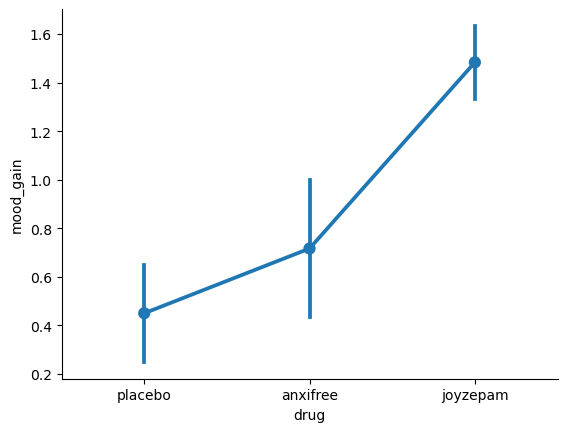

In [4]:
import seaborn as sns

fig = sns.pointplot(x='drug', y = 'mood_gain', data = df)
sns.despine()

 ```{glue:figure} moodgain_fig
:figwidth: 600px
:name: fig-moodgain

Average mood gain as a function of drug administered. Error bars depict 95% confidence intervals associated with each of the group means.
```


The results are shown in the figure above, which plots the average mood gain for all three conditions; error bars show 95\% confidence intervals. As the plot makes clear, there is a larger improvement in mood for participants in the Joyzepam group than for either the Anxifree group or the placebo group. The Anxifree group shows a larger mood gain than the control group, but the difference isn't as large. 

The question that we want to answer is: are these difference "real", or are they just due to chance?


(anovaintro)=
## How ANOVA works

In order to answer the question posed by our clinical trial data, we're going to run a one-way ANOVA. As usual, I'm going to start by showing you how to do it the hard way, building the statistical tool from the ground up and showing you how you could do it in Python if you didn't have access to any of the cool ANOVA functions that kind people have made for us. And, as always, I hope you'll read it carefully, try to do it the long way once or twice to make sure you really understand how ANOVA works, and then -- once you've grasped the concept -- never *ever* do it this way again.

The experimental design that I described in the previous section strongly suggests that we're interested in comparing the average mood change for the three different drugs. In that sense, we're talking about an analysis similar to the [$t$-test](ttest), but involving more than two groups. If we let $\mu_P$ denote the population mean for the mood change induced by the placebo, and let $\mu_A$ and $\mu_J$ denote the corresponding means for our two drugs, Anxifree and Joyzepam, then the (somewhat pessimistic) null hypothesis that we want to test is that all three population means are identical: that is, *neither* of the two drugs is any more effective than a placebo. Mathematically, we write this null hypothesis like this:

$$
\begin{array}{rcl}
H_0 &:& \mbox{it is true that } \mu_P = \mu_A = \mu_J
\end{array}
$$

As a consequence, our alternative hypothesis is that at least one of the three different treatments is different from the others. It's a little trickier to write this mathematically, because (as we'll discuss) there are quite a few different ways in which the null hypothesis can be false. So for now we'll just write the alternative hypothesis like this:

$$
\begin{array}{rcl}
H_1 &:& \mbox{it is *not* true that } \mu_P = \mu_A = \mu_J
\end{array}
$$

This null hypothesis is a lot trickier to test than any of the ones we've seen previously. How shall we do it? A sensible guess would be to "do an ANOVA", since that's the title of the chapter, but it's not particularly clear why an "analysis of *variances*" will help us learn anything useful about the *means*. In fact, this is one of the biggest conceptual difficulties that people have when first encountering ANOVA. To see how this works, I find it most helpful to start by talking about variances. In fact, what I'm going to do is start by playing some mathematical games with the formula that describes the variance. That is, we'll start out by playing around with variances, and it will turn out that this gives us a useful tool for investigating means.

### Two formulas for the variance of $Y$

Firstly, let's start by introducing some notation. We'll use $G$ to refer to the total number of groups. For our data set, there are three drugs, so there are $G=3$ groups. Next, we'll use $N$ to refer to the total sample size: there are a total of $N=18$ people in our data set. Similarly, let's use $N_k$ to denote the number of people in the $k$-th group. In our fake clinical trial, the sample size is $N_k = 6$ for all three groups.[^note1] Finally, we'll use $Y$ to denote the outcome variable: in our case, $Y$ refers to mood change. Specifically, we'll use $Y_{ik}$ to refer to the mood change experienced by the $i$-th member of the $k$-th group. Similarly, we'll use $\bar{Y}$ to be the average mood change, taken across all 18 people in the experiment, and $\bar{Y}_k$ to refer to the average mood change experienced by the 6 people in group $k$.  

Excellent. Now that we've got our notation sorted out, we can start writing down formulas. To start with, let's recall the formula for the variance that we used in, way back in those [kinder days](var) when we were just doing descriptive statistics. The sample variance of $Y$ is defined as follows:

$$
\mbox{Var}(Y) = \frac{1}{N} \sum_{k=1}^G \sum_{i=1}^{N_k} \left(Y_{ik} - \bar{Y} \right)^2
$$

This formula looks pretty much identical to the formula for the variance that we [used earlier](var) in the chapter on descriptive statistics. The only difference is that this time around I've got two summations here: I'm summing over groups (i.e., values for $k$) and over the people within the groups (i.e., values for $i$). This is purely a cosmetic detail: if I'd instead used the notation $Y_p$ to refer to the value of the outcome variable for person $p$ in the sample, then I'd only have a single summation. The only reason that we have a double summation here is that I've classified people into groups, and then assigned numbers to people within groups. 

A concrete example might be useful here. Let's consider this table, in which we have a total of $N=5$ people sorted into $G=2$ groups. Arbitrarily, let's say that the "cool" people are group 1, and the "uncool" people are group 2, and it turns out that we have three cool people ($N_1 = 3$) and two uncool people ($N_2 = 2$).

|name |person ($p$) |group  |group num ($k$) |index in group ($i$) |grumpiness ($Y_{ik}$ or $Y_p$) |
|:----|:------------|:------|:---------------|:--------------------|:------------------------------|
|Ann  |1            |cool   |1               |1                    |20                             |
|Ben  |2            |cool   |1               |2                    |55                             |
|Cat  |3            |cool   |1               |3                    |21                             |
|Dan  |4            |uncool |2               |1                    |91                             |
|Egg  |5            |uncool |2               |2                    |22                             |

Notice that I've constructed two different labelling schemes here. We have a "person" variable $p$, so it would be perfectly sensible to refer to $Y_p$ as the grumpiness of the $p$-th person in the sample. For instance, the table shows that Dan is the fourth person, so we'd say $p = 4$. So, when talking about the grumpiness $Y$ of this "Dan" person, whoever they might be, we could refer to Dan's grumpiness by saying that $Y_p = 91$, for person $p = 4$ that is.  However, that's not the only way we could refer to Dan. As an alternative, we could note that Dan belongs to the "uncool" group ($k = 2$), and is in fact the first person listed in the uncool group ($i = 1$). So it's equally valid to refer to Dan's grumpiness by saying that $Y_{ik} = 91$, where $k = 2$ and $i = 1$. In other words, each person $p$ corresponds to a unique $ik$ combination, and so the formula that I gave above is actually identical to our original formula for the variance, which would be

$$
\mbox{Var}(Y) = \frac{1}{N} \sum_{p=1}^N  \left(Y_{p} - \bar{Y} \right)^2
$$

In both formulas, all we're doing is summing over all of the observations in the sample. Most of the time we would just use the simpler $Y_p$ notation: the equation using $Y_p$ is clearly the simpler of the two. However, when doing an ANOVA it's important to keep track of which participants belong in which groups, and we need to use the $Y_{ik}$ notation to do this. 

### From variances to sums of squares

Okay, now that we've got a good grasp on how the variance is calculated, let's define something called the **_total sum of squares_**, which is denoted SS$_{tot}$. This is very simple: instead of averaging the squared deviations, which is what we do when calculating the variance, we just add them up. So the formula for the total sum of squares is almost identical to the formula for the variance:

$$
\mbox{SS}_{tot} = \sum_{k=1}^G \sum_{i=1}^{N_k} \left(Y_{ik} - \bar{Y} \right)^2
$$ 

When we talk about analysing variances in the context of ANOVA, what we're really doing is working with the total sums of squares rather than the actual variance. One very nice thing about the total sum of squares is that we can break it up into two different kinds of variation. Firstly, we can talk about the **_within-group sum of squares_**, in which we look to see how different each individual person is from their own group mean:

$$
\mbox{SS}_w = \sum_{k=1}^G \sum_{i=1}^{N_k} \left( Y_{ik} - \bar{Y}_k \right)^2
$$

where $\bar{Y}_k$ is a group mean. In our example, $\bar{Y}_k$ would be the average mood change experienced by those people given  the $k$-th drug. So, instead of comparing individuals to the average of *all* people in the experiment, we're only comparing them to those people in the the same group. As a consequence, you'd expect the value of $\mbox{SS}_w$ to be smaller than the total sum of squares, because it's completely ignoring any group differences -- that is, the fact that the drugs (if they work) will have different effects on people's moods.
 
Next, we can define a third notion of variation which captures *only* the differences between groups. We do this by looking at the differences between the group means $\bar{Y}_k$ and grand mean $\bar{Y}$. In order to quantify the extent of this variation, what we do is calculate the **_between-group sum of squares_**:

$$
\begin{array}{rcl}
\mbox{SS}_{b} &=& \sum_{k=1}^G \sum_{i=1}^{N_k} \left( \bar{Y}_k - \bar{Y} \right)^2
 \\
&=& \sum_{k=1}^G N_k \left( \bar{Y}_k - \bar{Y} \right)^2
\end{array}
$$

It's not too difficult to show that the total variation among people in the experiment $\mbox{SS}_{tot}$ is actually the sum of the differences between the groups $\mbox{SS}_b$ and the variation inside the groups $\mbox{SS}_w$. That is:

$$
\mbox{SS}_w  + \mbox{SS}_{b} = \mbox{SS}_{tot}
$$

Yay.

In [5]:

import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

mu1 = -4
mu2 = -.25
mu3 = 3.5
sigma = 2


x1 = np.linspace(mu1 - 4*sigma, mu1 + 4*sigma, 100)
y1 = 100* stats.norm.pdf(x1, mu1, sigma)
x2 = np.linspace(mu2 - 4*sigma, mu2 + 4*sigma, 100)
y2 = 100* stats.norm.pdf(x2, mu2, sigma)
x3 = np.linspace(mu3 - 4*sigma, mu3 + 4*sigma, 100)
y3 = 100* stats.norm.pdf(x3, mu3, sigma)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


sns.lineplot(x=x1,y=y1, color='black', ax = ax1)
sns.lineplot(x=x2,y=y2, color='black', ax = ax1)
sns.lineplot(x=x3,y=y3, color='black', ax = ax1)

sns.lineplot(x=x1,y=y1, color='black', ax = ax2)
sns.lineplot(x=x2,y=y2, color='black', ax = ax2)
sns.lineplot(x=x3,y=y3, color='black', ax = ax2)

ax1.text(0, 24, 'Between−group variation', size=20, ha="center")
ax1.text(0, 22, '(i.e., differences among group means))', size=20, ha="center")

ax2.text(0, 24, 'Within−group variation', size=20, ha="center")
ax2.text(0, 22, '(i.e., deviations from group means)', size=20, ha="center")


ax1.annotate(text = '', xy = (mu1,18), xytext = (mu2,18), arrowprops = dict(arrowstyle='<->'))
ax1.annotate(text = '', xy = (mu2,18), xytext = (mu3,18), arrowprops = dict(arrowstyle='<->'))
ax1.annotate(text = '', xy = (mu1,16), xytext = (mu3,16), arrowprops = dict(arrowstyle='<->'))

ax2.annotate(text = '', xy = (mu1-(sigma/2),18), xytext = (mu1+(sigma/2),18), arrowprops = dict(arrowstyle='<->'))
ax2.annotate(text = '', xy = (mu2-(sigma/2),18), xytext = (mu2+(sigma/2),18), arrowprops = dict(arrowstyle='<->'))
ax2.annotate(text = '', xy = (mu3-(sigma/2),18), xytext = (mu3+(sigma/2),18), arrowprops = dict(arrowstyle='<->'))


ax1.annotate(text = 'A', xy = (-12,16), size = 20)
ax2.annotate(text = 'B', xy = (-12,16), size = 20)


ax1.set_frame_on(False)
ax2.set_frame_on(False)
ax1.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax1.axhline(y=0, color='black')
ax2.axhline(y=0, color='black')

# show the figure in the book with caption
plt.close()
from myst_nb import glue
glue("anovavar_fig", fig, display=False)

 ```{glue:figure} anovavar_fig
:figwidth: 600px
:name: fig-anovavar

Graphical illustration of “between groups” variation (panel A) and “within groups” variation (panel B). On the left, the arrows show the differences in the group means; on the right, the arrows highlight the variability within each group.
```

Okay, so what have we found out? We've discovered that the total variability associated with the outcome variable ($\mbox{SS}_{tot}$) can be mathematically carved up into the sum of "the variation due to the differences in the sample means for the different groups" ($\mbox{SS}_{b}$) plus "all the rest of the variation" ($\mbox{SS}_{w}$). How does that help me find out whether the groups have different population means? Um. Wait. Hold on a second... now that I think about it, this is *exactly* what we were looking for. If the null hypothesis is true, then you'd expect all the sample means to be pretty similar to each other, right? And that would imply that you'd expect $\mbox{SS}_{b}$ to be really small, or at least you'd expect it to be a lot smaller than the "the variation associated with everything else", $\mbox{SS}_{w}$. Hm. I detect a hypothesis test coming on...

### From sums of squares to the $F$-test

As we saw in the last section, the *qualitative* idea behind ANOVA is to compare the two sums of squares values $\mbox{SS}_b$ and $\mbox{SS}_w$ to each other: if the between-group variation is $\mbox{SS}_b$ is large relative to the within-group variation $\mbox{SS}_w$ then we have reason to suspect that the population means for the different groups aren't identical to each other. In order to convert this into a workable hypothesis test, there's a little bit of "fiddling around" needed. What I'll do is first show you *what* we do to calculate our test statistic -- which is called an **_$F$ ratio_** -- and then try to give you a feel for *why* we do it this way. 

In order to convert our SS values into an $F$-ratio, the first thing we need to calculate is the **_degrees of freedom_** associated with the SS$_b$ and SS$_w$ values. As usual, the degrees of freedom corresponds to the number of unique "data points" that contribute to a particular calculation, minus the number of "constraints" that they need to satisfy. For the within-groups variability, what we're calculating is the variation of the individual observations ($N$ data points) around the group means ($G$ constraints). In contrast, for the between groups variability, we're interested in the variation of the group means ($G$ data points) around the grand mean (1 constraint). Therefore, the degrees of freedom here are:

$$
\begin{array}{lcl}
\mbox{df}_b &=& G-1 \\
\mbox{df}_w &=& N-G \\
\end{array}
$$

Okay, that seems simple enough. What we do next is convert our summed squares value into a "mean squares" value, which we do by dividing by the degrees of freedom: 

$$
\begin{array}{lcl}
\mbox{MS}_b &=& \displaystyle\frac{\mbox{SS}_b }{ \mbox{df}_b} \\
\mbox{MS}_w &=& \displaystyle\frac{\mbox{SS}_w }{ \mbox{df}_w} 
\end{array}
$$

Finally, we calculate the $F$-ratio by dividing the between-groups MS by the within-groups MS:

$$
F = \frac{\mbox{MS}_b }{ \mbox{MS}_w } 
$$

At a very general level, the intuition behind the $F$ statistic is straightforward: bigger values of $F$ means that the between-groups variation is large, relative to the within-groups variation. As a consequence, the larger the value of $F$, the more evidence we have against the null hypothesis. But how large does $F$ have to be in order to actually *reject* $H_0$? In order to understand this, you need a slightly deeper understanding of what ANOVA is and what the mean squares values actually are. 

The next section discusses that in a bit of detail, but for readers that aren't interested in the details of what the test is actually measuring, I'll cut to the chase. In order to complete our hypothesis test, we need to know the sampling distribution for $F$ if the null hypothesis is true. Not surprisingly, the sampling distribution for the $F$ *statistic* under the null hypothesis is an $F$ *distribution*. If you recall back to our discussion of the $F$ distribution in [](probability), the $F$ distribution has two parameters, corresponding to the two degrees of freedom involved: the first one df$_1$ is the between groups degrees of freedom df$_b$, and the second one df$_2$ is the within groups degrees of freedom df$_w$. 

A summary of all the key quantities involved in a one-way ANOVA, including the formulas showing how they are calculated, is shown in the table below:

|               |df                  |sum of squares                                                     |mean squares                                     |$F$ statistic                            |$p$ value     |
|:--------------|:-------------------|:------------------------------------------------------------------|:------------------------------------------------|:----------------------------------------|:-------------|
|between groups |$\mbox{df}_b = G-1$ |SS$_b = \displaystyle\sum_{k=1}^G N_k (\bar{Y}_k - \bar{Y})^2$     |$\mbox{MS}_b = \frac{\mbox{SS}_b}{\mbox{df}_b}$  |$F = \frac{\mbox{MS}_b }{ \mbox{MS}_w }$ |[complicated] |
|within groups  |$\mbox{df}_w = N-G$ |SS$_w = \sum_{k=1}^G \sum_{i = 1}^{N_k} ( {Y}_{ik} - \bar{Y}_k)^2$ |$\mbox{MS}_w =  \frac{\mbox{SS}_w}{\mbox{df}_w}$ |-                                        |-             |


(anovamodel)=
### The model for the data and the meaning of $F$ (advanced)

At a fundamental level, ANOVA is a competition between two different statistical models, $H_0$ and $H_1$. When I described the null and alternative hypotheses at the start of the section, I was a little imprecise about what these models actually are. I'll remedy that now, though you probably won't like me for doing so. If you recall, our null hypothesis was that all of the group means are identical to one another. If so, then a natural way to think about the outcome variable $Y_{ik}$ is to describe individual scores in terms of a single population mean $\mu$, plus the deviation from that population mean. This deviation is usually denoted $\epsilon_{ik}$ and is traditionally called the *error* or **_residual_** associated with that observation. Be careful though: just like we saw with the word "significant", the word "error" has a technical meaning in statistics that isn't quite the same as its everyday English definition. In everyday language, "error" implies a mistake of some kind; in statistics, it doesn't (or at least, not necessarily). With that in mind, the word "residual" is a better term than the word "error". In statistics, both words mean "leftover variability": that is, "stuff" that the model can't explain. In any case, here's what the null hypothesis looks like when we write it as a statistical model:

$$
Y_{ik} = \mu + \epsilon_{ik}
$$

where we make the *assumption* (discussed later) that the residual values $\epsilon_{ik}$ are normally distributed, with mean 0 and a standard deviation $\sigma$ that is the same for all groups. To use the notation that we introduced in the [chapter on probability](probability) we would write this assumption like this:

$$
\epsilon_{ik} \sim \mbox{Normal}(0, \sigma^2)
$$

What about the alternative hypothesis, $H_1$? The only difference between the null hypothesis and the alternative hypothesis is that we allow each group to have a different population mean. So, if we let $\mu_k$ denote the population mean for the $k$-th group in our experiment, then the statistical model corresponding to $H_1$ is:

$$
Y_{ik} = \mu_k + \epsilon_{ik}
$$

where, once again, we assume that the error terms are normally distributed with mean 0 and standard deviation $\sigma$. That is, the alternative hypothesis also assumes that 

$$
\epsilon_{ik} \sim \mbox{Normal}(0, \sigma^2)
$$

Okay, now that we've described the statistical models underpinning $H_0$ and $H_1$ in more detail, it's now pretty straightforward to say what the mean square values are measuring, and what this means for the interpretation of $F$. I won't bore you with the proof of this, but it turns out that the within-groups mean square, MS$_w$, can be viewed as an estimator (in the technical sense: [estimation](estimation) of the error variance $\sigma^2$.  The between-groups mean square MS$_b$ is also an estimator; but what it estimates is the error variance *plus* a quantity that depends on the true differences among the group means. If we call this quantity $Q$, then we can see that the $F$-statistic is basically [^note2]

$$
F = \frac{\hat{Q} + \hat\sigma^2}{\hat\sigma^2}
$$

where the true value $Q=0$ if the null hypothesis is true, and $Q > 0$ if the alternative hypothesis is true (if you must know more, than check out chapter 10 of {cite}`Hays1994`). Therefore, at a bare minimum *the $F$ value must be larger than 1* to have any chance of rejecting the null hypothesis. Note that this *doesn't* mean that it's impossible to get an $F$-value less than 1. What it means is that, if the null hypothesis is true, then the sampling distribution of the $F$ ratio has a mean of 1,[^note3] and so we need to see $F$-values larger than 1 in order to safely reject the null.

To be a bit more precise about the sampling distribution, notice that if the null hypothesis is true, both MS$_b$ and MS$_w$ are estimators of the variance of the residuals $\epsilon_{ik}$. If those residuals are normally distributed, then you might suspect that the estimate of the variance of $\epsilon_{ik}$ is chi-square distributed... because (as discussed [much earlier](otherdists)) that's what a chi-square distribution *is*: it's what you get when you square a bunch of normally-distributed things and add them up. And since the $F$ distribution is (again, by definition) what you get when you take the ratio between two things that are $\chi^2$ distributed... we have our sampling distribution. Obviously, I'm glossing over a whole lot of stuff when I say this, but in broad terms, this really is where our sampling distribution comes from.

(anovacalc)=
### A worked example

The previous discussion was fairly abstract, and a little on the technical side, so I think that at this point it might be useful to see a worked example. For that, let's go back to the clinical trial data that I introduced at the start of the chapter. The descriptive statistics that we calculated at the beginning tell us our group means: an average mood gain of 0.45 for the placebo, 0.72 for Anxifree, and 1.48 for Joyzepam. With that in mind, let's party like it's 1899 [^note4] and  start doing some pencil and paper calculations. I'll only do this for the first 5 observations, because it's not bloody 1899 and I'm very lazy. Let's start by calculating $\mbox{SS}_{w}$, the within-group sums of squares. First, let's draw up a nice table to help us with our calculations... 


|group ($k$) |outcome ($Y_{ik}$) |
|:-----------|:------------------|
|placebo     |0.5                |
|placebo     |0.3                |
|placebo     |0.1                |
|anxifree    |0.6                |
|anxifree    |0.4                |

At this stage, the only thing I've included in the table is the raw data itself: that is, the grouping variable (i.e., `drug`) and outcome variable (i.e. `mood_gain`) for each person. Note that the outcome variable here corresponds to the $Y_{ik}$ value in our equation previously. The next step in the calculation is to write down, for each person in the study, the corresponding group mean; that is, $\bar{Y}_k$. This is slightly repetitive, but not particularly difficult since we already calculated those group means when doing our descriptive statistics:


|group ($k$) |outcome ($Y_{ik}$) |**group mean** ($\bar{Y}_k$) |
|:-----------|:------------------|:----------------------------|
|placebo     |0.5                |**0.45**                     |
|placebo     |0.3                |**0.45**                     |
|placebo     |0.1                |**0.45**                     |
|anxifree    |0.6                |**0.72**                     |
|anxifree    |0.4                |**0.72**                     |



Now that we've written those down, we need to calculate -- again for every person -- the deviation from the corresponding group mean. That is, we want to subtract $Y_{ik} - \bar{Y}_k$. After we've done that, we need to square everything. When we do that, here's what we get:


|group ($k$) |outcome ($Y_{ik}$) |group mean ($\bar{Y}_k$) |**dev. from group mean** ($Y_{ik} - \bar{Y}_{k}$) |**squared deviation** ($(Y_{ik} - \bar{Y}_{k})^2$) |
|:-----------|:------------------|:------------------------|:--------------------------------------------------|:--------------------------------------------------|
|placebo     |0.5                |0.45                     |**0.05**                                           |**0.0025**                                         |
|placebo     |0.3                |0.45                     |**-0.15**                                          |**0.0225**                                         |
|placebo     |0.1                |0.45                     |**-0.35**                                          |**0.1225**                                         |
|anxifree    |0.6                |0.72                     |**-0.12**                                          |**0.0136**                                         |
|anxifree    |0.4                |0.72                     |**-0.32**                                          |**0.1003**                                         |


The last step is equally straightforward. In order to calculate the within-group sum of squares, we just add up  the squared deviations across all observations:

$$
\begin{array}{rcl}
\mbox{SS}_w &=& 0.0025 + 0.0225 + 0.1225 + 0.0136 + 0.1003 \\
&=& 0.2614
\end{array}
$$

Of course, if we actually wanted to get the *right* answer, we'd need to do this for all 18 observations in the data set, not just the first five. We could continue with the pencil and paper calculations if we wanted to, but it's pretty tedious. Alternatively, click the button to see how we can get Python to do this tedious work for us [^tedium]:

[^tedium]: Ok, I suppose you could make a pretty solid case that writing all this code to do a bit of multiplication and substraction is also tedious, but I would counter your argument by pointing out that coding your way to these solutions has the benefit of being reproducible (if you later discover a mistake, you can trace it back and fix it) and resusable (next time you want to do solve a similar problem, you can take your old code and modify it, because now you already know how to do that sort of thing). Plus, doing it by hand is maybe ok for 18 participants, but what if you had a study with five hundred or a thousand participants, hmmm...?

In [6]:
# select the columns from the dataframe with the group and outcome measure data
# this is not strictly necessary, but it makes it clearer what we are doing when we plug these data back into the new dataframe Y
group = df['drug']
outcome = df['mood_gain']

# make a new dataframe called grouped, in which our data are associated by which group (drug treatment) the participant was in
grouped = df.groupby('drug')

# make a dataframe with the mean values for each group
gp_means = grouped.mean(numeric_only=True)

# flatten the indices of the new dataframe gp_means, because multiindices can be pretty annoying
gp_means.reset_index(inplace=True)

# make a list (grouped_means) that the is the length of the number of participants (which we get from the length of the variable "group",
# which contained all the rows of the original dataframe)
grouped_means = [0]*len(group)

# go through every row in the dataframe "gp_means", which contains the names of the three drugs,
# then check in every row of the variable group (which contains the drug name for each participant)
# and if the drug names match, put the mean mood gain in the corresponding row of "grouped_means"
for s, val in enumerate(gp_means['drug']):
    for x, drug in enumerate(group):
        if val == drug:
            grouped_means[x] = round(gp_means['mood_gain'][s],2)

# build a new dataframe Y with a row for each participant, with columns for drug name (group), each participants' outcome (mood gain),
# and the average (mean) mood gain for all particpants who were in the same treatment group.
Y = pd.DataFrame(
    {'group': group,
     'outcome': outcome,
     'group_means': grouped_means
    }) 

# add a column to the dataframe Y showing the distance (residual) of each individual from their group's mean
Y['dev_from_group_means'] = Y['outcome'] - Y['group_means']

# add a column to the dataframe Y with the same values as the column before (residuals), but squared (multiplied by themeselves)
Y['squared_devs'] = Y['dev_from_group_means']**2


This is where the basic Python [skills](getting-started-with-python), programming [skills](programming), and data-wrangling [skills](datawrangling) you learned way back at the beginning of this book really start to pay off. It might not be obvious from inspection what these commands are doing: as a general rule, the human brain seems to just shut down when faced with a big block of programming. However, I strongly suggest that -- if you're like me and tend to find that the mere sight of this code makes you want to look away and see if there's any beer left in the fridge or a game of footy on the telly -- you take a moment and look closely at these commands, and the many comments I have written, one at a time. Every single one of these commands is something you've seen before somewhere else in the book. There's nothing novel about them (though I admit that `reset_index` has appeared only once, and there aren't many nested `for` statements in this book), so if you're not quite sure how these commands work, this might be a good time to try playing around with them yourself, to try to get a sense of what's happening. On the other hand, if this does seem to make sense, then you won't be all that surprised at what happens when we look at the output of all this code, `Y`, and we see...

In [7]:
Y

,group,outcome,group_means,dev_from_group_means,squared_devs
0,placebo,0.5,0.45,0.05,0.0025
1,placebo,0.3,0.45,-0.15,0.0225
2,placebo,0.1,0.45,-0.35,0.1225
3,anxifree,0.6,0.72,-0.12,0.0144
4,anxifree,0.4,0.72,-0.32,0.1024
5,anxifree,0.2,0.72,-0.52,0.2704
6,joyzepam,1.4,1.48,-0.08,0.0064
7,joyzepam,1.7,1.48,0.22,0.0484
8,joyzepam,1.3,1.48,-0.18,0.0324
9,placebo,0.6,0.45,0.15,0.0225


If you compare this output to the contents of the table I've been constructing by hand, you can see that Python has done exactly the same calculations that I was doing (albeit with a few miniscule differences due to rounding), and much faster too. So, if we want to finish the calculations of the within-group sum of squares in Python, we just ask for the `sum()` of the `squared_devs` variable:

In [8]:
SSw = Y['squared_devs'].sum()
SSw

1.3918000000000001

Okay. Now that we've calculated the within groups variation, $\mbox{SS}_w$, it's time to turn our attention to the between-group sum of squares, $\mbox{SS}_b$. The calculations for this case are very similar. The main difference is that, instead of calculating the differences between an observation $Y_{ik}$ and a group mean $\bar{Y}_k$ for all of the observations, we calculate the differences between the group means $\bar{Y}_k$ and the grand mean $\bar{Y}$ (in this case 0.88) for all of the groups...


|group ($k$) |group mean ($\bar{Y}_k$) |grand mean ($\bar{Y}$) |deviation ($\bar{Y}_{k} - \bar{Y}$) |squared deviations ($(\bar{Y}_{k} - \bar{Y})^2$) |
|:-----------|:------------------------|:----------------------|:-----------------------------------|:------------------------------------------------|
|placebo     |0.45                     |0.88                   |-0.43                               |0.18                                             |
|anxifree    |0.72                     |0.88                   |-0.16                               |0.03                                             |
|joyzepam    |1.48                     |0.88                   |0.60                                |0.36                                             |

However, for the between group calculations we need to multiply each of these squared deviations by $N_k$, the number of observations in the group. We do this because every *observation* in the group (all $N_k$ of them) is associated with a between group difference. So if there are six people in the placebo group, and the placebo group mean differs from the grand mean by 0.19, then the *total* between group variation associated with these six people is $6 \times 0.16 = 1.14$. So we have to extend our little table of calculations...


|group ($k$) |squared deviations ($(\bar{Y}_{k} - \bar{Y})^2$) |sample size ($N_k$) |weighted squared dev ($N_k (\bar{Y}_{k} - \bar{Y})^2$) |
|:-----------|:------------------------------------------------|:-------------------|:------------------------------------------------------|
|placebo     |0.18                                             |6                   |1.11                                                   |
|anxifree    |0.03                                             |6                   |0.16                                                   |
|joyzepam    |0.36                                             |6                   |2.18                                                   |


And so now our between group sum of squares is obtained by summing these "weighted squared deviations" over all three groups in the study:

$$
\begin{array}{rcl}
\mbox{SS}_{b} &=& 1.11 + 0.16 + 2.18 \\
&=& 3.45
\end{array}
$$


As you can see, the between group calculations are a lot shorter, so you probably wouldn't usually want to bother using Python as your calculator. However, if you *did* decide to do so, here's one way you could do it:

In [9]:
grouped = df.groupby('drug')
gp_means = grouped.mean(numeric_only=True)
gp_means.reset_index(inplace=True)
group = list(gp_means['drug'])
gp_means = list(gp_means['mood_gain'])

grand_mean = round(df['mood_gain'].mean(),2)
grand_mean = [grand_mean]*3



Y = pd.DataFrame(
    {'group': group,
     'gp_means': gp_means,
     'grand_mean': grand_mean 
    }) 

Y['dev_from_grandmean'] = Y['gp_means'] - Y['grand_mean']
Y['squared_devs'] = Y['dev_from_grandmean']**2

xtab = pd.crosstab(index = df["drug"], columns = "count")
xtab.reset_index(inplace=True)

Y['group_sizes'] = xtab['count']
Y['weighted_squared_devs'] = Y['group_sizes'] * Y['squared_devs']




I won't actually try to explain this code line by line this time, but -- just like last time -- there's nothing in there that we haven't seen in several places elsewhere in the book, so I'll leave it as an exercise for you to make sure you understand it. Once again, we can dump all our variables into a data frame so that we can print it out as a nice table:

In [10]:
Y

,group,gp_means,grand_mean,dev_from_grandmean,squared_devs,group_sizes,weighted_squared_devs
0,anxifree,0.716667,0.88,-0.163333,0.026678,6,0.160067
1,joyzepam,1.483333,0.88,0.603333,0.364011,6,2.184067
2,placebo,0.450000,0.88,-0.430000,0.184900,6,1.109400


Clearly, these are basically the same numbers that we got before. There are a few tiny differences, but that's only because the hand-calculated versions have some small errors caused by the fact that I rounded all my numbers to 2 decimal places at each step in the calculations, whereas Python only does it at the end (obviously, Python's version is more accurate). Anyway, here's the Python command showing the final step:

In [11]:
SSb = sum(Y['weighted_squared_devs'])
SSb

3.453533333333334

which is (ignoring the slight differences due to rounding error) the same answer that I got when doing things by hand.

Now that we've calculated our sums of squares values, $\mbox{SS}_b$ and $\mbox{SS}_w$, the rest of the ANOVA is pretty painless. The next step is to calculate the degrees of freedom. Since we have $G = 3$ groups and $N = 18$ observations in total, our degrees of freedom can be calculated by simple subtraction:

$$
\begin{array}{lclcl}
\mbox{df}_b &=& G - 1 &=& 2 \\
\mbox{df}_w &=& N - G &=& 15 
\end{array}
$$

Next, since we've now calculated the values for the sums of squares and the degrees of freedom, for both the within-groups variability and the between-groups variability, we can obtain the mean square values by dividing one by the other:

$$
\begin{array}{lclclcl}
\mbox{MS}_b &=& \displaystyle\frac{\mbox{SS}_b }{  \mbox{df}_b } &=& \displaystyle\frac{3.45}{ 2}  &=& 1.73
\end{array}
$$

$$
\begin{array}{lclclcl}
\mbox{MS}_w &=& \displaystyle\frac{\mbox{SS}_w }{  \mbox{df}_w } &=& \displaystyle\frac{1.39}{15} &=& 0.09
\end{array}
$$

We're almost done. The mean square values can be used to calculate the $F$-value, which is the test statistic that we're interested in. We do this by dividing the between-groups MS value by the and within-groups MS value.

$$
F \ = \ \frac{\mbox{MS}_b }{ \mbox{MS}_w } \ = \ \frac{1.73}{0.09} \ = \ 18.6
$$

Woohooo! This is terribly exciting, yes? Now that we have our test statistic, the last step is to find out whether the test itself gives us a significant result. As discussed back when we talked about [hypothesis testing](hypothesistesting), what we really *ought* to do is choose an $\alpha$ level (i.e., acceptable Type I error rate) ahead of time, construct our rejection region, etc etc. But in practice it's just easier to directly calculate the $p$-value. Back in the "old days", what we'd do is open up a statistics textbook or something and flick to the back section which would actually have a huge lookup table... that's how we'd "compute" our $p$-value, because it's too much effort to do it any other way. However, since we have access to Python, I'll use the `stats.f.cdf()` method from `scipy` to do it instead.[^eveneasier]

[^eveneasier]: In fact, in practice we won't do any of this stuff. As we'll see in a minute, there are already modules for Python that will just take care of all of these steps for us, including calculating the $p$-value. But we're still doing things "by hand" here, remember?

In [12]:
from scipy import stats
p = 1-stats.f.cdf(18.6, 2, 15)
p

8.672726890401883e-05

(onewayanovatable)=
Therefore, our $p$-value comes to 0.0000867, or $8.67 \times 10^{-5}$ in scientific notation. So, unless we're being *extremely* conservative about our Type I error rate, we're pretty much guaranteed to reject the null hypothesis. 

At this point, we're basically done. Having completed our calculations, it's traditional to organise all these numbers into an ANOVA table like the one below:


|               |df |sum of squares |mean squares |$F$-statistic |$p$-value             |
|:--------------|:--|:--------------|:------------|:-------------|:---------------------|
|between groups |2  |3.45           |1.73         |18.6          |$8.67 \times 10^{-5}$ |
|within groups  |15 |1.39           |0.09         |-             |-                     |


These days, you'll probably never have much reason to want to construct one of these tables yourself, but you *will* find that almost all statistical software tends to organise the output of an ANOVA into a table like this, so it's a good idea to get used to reading them. However, although the software will output a full ANOVA table, there's almost never a good reason to include the whole table in your write up. A pretty standard way of reporting this result would be to write something like this:

> "One-way ANOVA showed a significant effect of drug on mood gain ($F(2,15) = 18.6, p<.001$)."

Sigh. So much work for one short sentence.

(introduceaov)=
## Running an ANOVA in Python

I'm pretty sure I know what you're thinking after reading the last section, *especially* if you followed my advice and tried typing all the commands in yourself.... doing the ANOVA calculations yourself *sucks*. There's quite a lot of calculations that we needed to do along the way, and it would be tedious to have to do this over and over again every time you wanted to do an ANOVA. One possible solution to the problem would be to take all these calculations and turn them into some Python functions yourself. You'd still have to do a lot of typing, but at least you'd only have to do it the one time: once you've created the functions, you can reuse them over and over again. However, writing your own functions is a lot of work, so this is kind of a last resort. Besides, it's much better if someone else does all the work for you...

### Getting Python to calculate ANOVA for you

Now, as you can imagine, there are several Python modules available that provided tools for taking the pain out calculating ANOVA's. `scipy`, for example, has `stats.f_oneway` which, in the typical, laconic fashion of `scipy`, spits out an $F$-value, a $p$-value, and not much more. We have already used `scipy.stats` above to find our $p$-value by hand. I am going to reccomend an entirely different package, though: `statsmodels`. These things go in and out of fashion, but for my money, `statsmodels` is quickly becoming the go-to Python package for anthing beyond a humble $t$-test. `statsmodels` builds on a more modern approach to statistics which goes beyond what we can deal with here, but suffice to say, that among other things, it is an easy way to get your ANOVA work done. 

The key to working with `statsmodels` is the `formula`, so let's take a look at that. A `statsmodels` formula (which will instantly feel familiar to anyone who has worked with the programming language R before) begins with the _dependent variable_ or _outcome measure_: basically the thing we are trying to undersand. The _outcome measure_ goes on the left side of the `~`character, which I read in my head as "predicted by". To the right of the `~` comes, unsurprisingly, the _predictor variables_, or _independent variables_ if you prefer. So, in our case, we are investigating whether or not there are significant differences between the three drug types: placebo, anxifree, and joyzepam. In other words, we want to know if variation in the variable `mood_gain` that can be accounted for by these three groups is greater than the variation within the groups. Or, in still other words, whether `mood_gain` can be _predicted by_ `drug`. So, our formula is `'mood_gain ~ drug'`.

Before we run the ANOVA, let's just remember what the data look like:

In [13]:
df.head()

,drug,therapy,mood_gain
0,placebo,no.therapy,0.5
1,placebo,no.therapy,0.3
2,placebo,no.therapy,0.1
3,anxifree,no.therapy,0.6
4,anxifree,no.therapy,0.4


Now, let's let `statsmodels` do its magic. To do the same ANOVA that I laboriously calculated in the previous section, I’d use a few simple commands like this:

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'mood_gain ~ drug'

model = ols(formula, data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=2)
aov_table


,sum_sq,df,F,PR(>F)
drug,3.453333,2.0,18.610778,0.000086
Residual,1.391667,15.0,NaN,NaN


Now, isn't that better? We got to the same place, but with a lot less pain and suffering!

Once we get done celebrating, we might take a little closer look at this wonder function. The function is called `anova_lm`. The ANOVA part makes sense, sure, but what is this `lm` thing all about? `lm` stands for "linear model", and later on, we'll see that this reflects a pretty deep statistical relationship between ANOVA and [linear regression](regression), and this has some important implications for what can be done with both ANOVAs and linear regressions... but I'm getting ahead of myself. For now, let's just bask in the glory of the anova table that `statsmodels` gives us. We get the sums of squares, the degrees of freedom, the $F$-statistic, and the $p$-value itself. These are all identical to the numbers that we calculated ourselves when doing it the long and tedious way, and it's even organised into a nice table, like the [one that we filled out by hand](onewayanovatable). You might be wondering what the ``NaN``s in the last two cells are. If you compare this table to the [one that we filled out by hand](onewayanovatable), you will see that these are simply empty cells; it doesn't make sense to calculate an $F$-value or $p$-value for the residuals. ``NaN`` just means "not a number". It would be nicer if ``statsmodels`` just left these cells empty, but after all the work it has just done for us, I'm willing to overlook this.

So, `statsmodels` provides a pretty easy way to get ANOVAs done, but back when we were doing t-tests, I was all excited about `pingouin` and said it made things so much easier. So couldn't we use `pingouin` to do ANOVA's? Sure, of course we can!

In [15]:
import pingouin as pg

pg.anova(dv='mood_gain', 
         between='drug', 
         data=df,
         detailed=True)



,Source,SS,DF,MS,F,p-unc,np2
0,drug,3.453333,2,1.726667,18.610778,0.000086,0.712762
1,Within,1.391667,15,0.092778,NaN,NaN,NaN


If you check, you'll see we get the same answer either way. So that's _two_ easy ways to do ANOVA in Python! Time for beer and football!


(etasquared)=
## Effect size


There's a few different ways you could measure the effect size in an ANOVA, but the most commonly used measures are $\eta^2$ (**_eta squared_**) and partial $\eta^2$. For a one way analysis of variance they're identical to each other, so for the moment I'll just explain $\eta^2$. The definition of $\eta^2$ is actually really simple:

$$
\eta^2 = \frac{\mbox{SS}_b}{\mbox{SS}_{tot}}
$$

That's all it is. So when I look at the ANOVA table above, I see that $\mbox{SS}_b = 3.45$  and $\mbox{SS}_{tot} = 3.45 + 1.39 = 4.84$. Thus we get an $\eta^2$ value of 

$$
\eta^2 = \frac{3.45}{4.84} = 0.71
$$

The interpretation of $\eta^2$ is equally straightforward: it refers to the proportion of the variability in the outcome variable (`mood_gain`) that can be explained in terms of the predictor (`drug`). A value of $\eta^2 = 0$ means that there is no relationship at all between the two, whereas a value of $\eta^2 = 1$ means that the relationship is perfect. Better yet, the $\eta^2$ value is very closely related to a squared correlation (i.e., $r^2$). So, if you're trying to figure out whether a particular value of $\eta^2$ is big or small, it's sometimes useful to remember that 

$$
\eta= \sqrt{\frac{\mbox{SS}_b}{\mbox{SS}_{tot}}}
$$

can be interpreted as if it referred to the *magnitude* of a Pearson correlation. So in our drugs example, the $\eta^2$ value of .71 corresponds to an $\eta$ value of $\sqrt{.71} = .84$. If we think about this as being equivalent to a correlation of about .84, we'd conclude that the relationship between `drug` and `mood_gain` is strong. 

It's pretty straightforward to calculate it directly from the numbers in the ANOVA table. In fact, since I've already got the `SSw` and `SSb` variables lying around from my earlier calculations, I can do this:

In [16]:
SStot = SSb + SSw          # total sums of squares
eta_squared = SSb / SStot  # eta-squared value
eta_squared

0.7127545404512933

And, in fact, if you look at the last column in the `pingouin` output above, you'll see that `pingouin` has already calculated $\eta^2$ for us.

(posthoc)=
## Multiple comparisons and post hoc tests

Any time you run an ANOVA with more than two groups, and you end up with a significant effect, the first thing you'll probably want to ask is which groups are actually different from one another. In our drugs example, our null hypothesis was that all three drugs (placebo, Anxifree and Joyzepam) have the exact same effect on mood. But if you think about it, the null hypothesis is actually claiming *three* different things all at once here. Specifically, it claims that:

- Your competitor's drug (Anxifree) is no better than a placebo (i.e., $\mu_A = \mu_P$)
- Your drug (Joyzepam) is no better than a placebo (i.e., $\mu_J = \mu_P$)
- Anxifree and Joyzepam are equally effective (i.e., $\mu_J = \mu_A$)

If any one of those three claims is false, then the null hypothesis is also false. So, now that we've rejected our null hypothesis, we're thinking that *at least* one of those things isn't true. But which ones? All three of these propositions are of interest: you certainly want to know if your new drug Joyzepam is better than a placebo, and it would be nice to know how well it stacks up against an existing commercial alternative (i.e., Anxifree). It would even be useful to check the performance of Anxifree against the placebo: even if Anxifree has already been extensively tested against placebos by other researchers, it can still be very useful to check that your study is producing similar results to earlier work.

When we characterise the null hypothesis in terms of these three distinct propositions, it becomes clear that there are eight possible "states of the world" that we need to distinguish between:


|possibility: |is $\mu_P = \mu_A$? |is $\mu_P = \mu_J$? |is $\mu_A = \mu_J$? |which hypothesis? |
|:------------|:-------------------|:-------------------|:-------------------|:-----------------|
|1            |$\checkmark$        |$\checkmark$        |$\checkmark$        |null              |
|2            |$\checkmark$        |$\checkmark$        |                    |alternative       |
|3            |$\checkmark$        |                    |$\checkmark$        |alternative       |
|4            |$\checkmark$        |                    |                    |alternative       |
|5            |                    |$\checkmark$        |$\checkmark$        |alternative       |
|6            |                    |$\checkmark$        |                    |alternative       |
|7            |                    |                    |$\checkmark$        |alternative       |
|8            |                    |                    |                    |alternative       |
> 

By rejecting the null hypothesis, we've decided that we *don't* believe that \#1 is the true state of the world. The next question to ask is, which of the other seven possibilities *do* we think is right? When faced with this situation, its usually helps to look at the data. For instance, remember the figure we made at the beginning of this chapter, that looked like this?

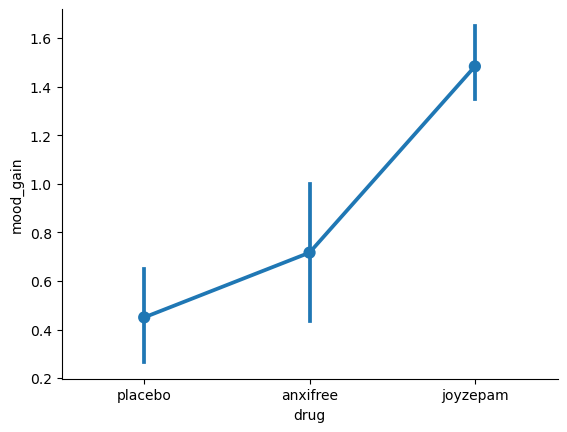

In [17]:
import seaborn as sns

fig = sns.pointplot(x='drug', y = 'mood_gain', data = df)
sns.despine()

Looking at the figure, it's tempting to conclude that Joyzepam is better than the placebo and better than Anxifree, but there's no real difference between Anxifree and the placebo. However, if we want to get a clearer answer about this, it might help to run some tests. 

### Running "pairwise" $t$-tests

How might we go about solving our problem? Given that we've got three separate pairs of means (placebo versus Anxifree, placebo versus Joyzepam, and Anxifree versus Joyzepam) to compare, what we could do is run three separate $t$-tests and see what happens. There's a couple of ways that we could do this. One method would be to construct new variables corresponding the groups you want to compare (e.g., `anxifree`, `placebo` and `joyzepam`), and then run a $t$-test on these new variables.

(fwer)=
This "lots of $t$-tests idea" isn't a bad strategy, but there is a problem with just running lots and lots of $t$-tests. The concern is that when running these analyses, what we're doing is going on a "fishing expedition": we're running lots and lots of tests without much theoretical guidance, in the hope that some of them come up significant. This kind of theory-free search for group differences is referred to as **_post hoc analysis_** ("post hoc" being Latin for "after this").[^plannedcomparisons]   

It's okay to run post hoc analyses, but a lot of care is required, because post-hoc t-tests can be pretty dangerous: each *individual* $t$-test is designed to have a 5\% Type I error rate (i.e., $\alpha = .05$), but imagine if I ran three of these tests. Intuitively, you may be able to feel that if every test I do has a 5\% chance of committing a Type I error, then the more tests I do on the same set of data, the more likely that at least _some_ of them will lead me to incorrectly reject the null hypothesis. 

In fact, we can calculate a statistic that tells us just how risky it is to conduct many post-hoc $t$-tests on our data. It's called the _family-wise error rate_, and looks like this:

$$FWER = 1-(1-\alpha)^m$$

where $m$ is the number of tests I do. So, while we might feel fine about choosing an $\alpha$ of 0.05 for one $t$-test, which gives us a 5\% chance of committing a Type I error, we might not feel so hot about running three post-hoc $t$-tests on our data, since 

$$1-(1-0.05)^3=0.142625$$

Now the family-wise error rate is 0.14 -- in other words, we have now gone from a 5\% chance of incorrectly rejecting a null hypothesis to a nearly 15\% chance of incorrectly rejecting a null hypothesis, and maybe those odds don't feel so good anymore. If we did 100 $t$-tests on our data, each with an $\alpha$ of 0.05, now the FWER goes up to

$$1-(1-0.05)^{100}=0.99407947$$

That is, it is nearly certain that we will be incorrectly rejecting some null hypotheses, but which ones? We have no idea.

As we saw when we talked about [hypothesis testing](hypothesistesting), the central organising principle behind null hypothesis testing is that we seek to control our Type I error rate, but once I start running lots of $t$-tests at once, in order to determine the source of my ANOVA results, my actual Type I error rate across this whole *family* of tests has gotten completely out of control. 


(correctionformultiplecomarisons)=

The usual solution to this problem is to introduce an adjustment to the $p$-value, which aims to control the total error rate across the family of tests (see {cite}`Shaffer1995`). An adjustment of this form, which is usually (but not always) applied because one is doing post hoc analysis, is often referred to as a **_correction for multiple comparisons_**, though it is sometimes referred to as "simultaneous inference". In any case, there are quite a few different ways of doing this adjustment. I'll discuss a few of them in this section and in [a later section](posthoc2), but you should be aware that there are many other methods out there (see, e.g., {cite}`Hsu1996`). 

### Bonferroni corrections


The simplest of these adjustments is called the **_Bonferroni correction_** {cite}`Dunn1961`, and it's very very simple indeed. Suppose that my post hoc analysis consists of $m$ separate tests, and I want to ensure that the total probability of making *any* Type I errors at all is at most $\alpha$.[^bonf] If so, then the Bonferroni correction just says "multiply all your raw $p$-values by $m$". If we let $p$ denote the original $p$-value, and let $p^\prime_j$ be the corrected value, then the Bonferroni correction tells that:

$$
p^\prime = m \times p
$$

And therefore, if you're using the Bonferroni correction, you would reject the null hypothesis if $p^\prime < \alpha$. The logic behind this correction is very straightforward. We're doing $m$ different tests; so if we arrange it so that each test has a Type I error rate of at most $\alpha / m$, then the *total* Type I error rate across these tests cannot be larger than $\alpha$. That's pretty simple, so much so that in the original paper, the author writes:

> The method given here is so simple and so general that I am sure it must have been used before this. I do not find it, however, so can only conclude that perhaps its very simplicity has kept statisticians from realizing that it is a very good method in some situations (pp 52-53 {cite}`Dunn1961`)

### Holm corrections

Although the Bonferroni correction is the simplest adjustment out there, it's not usually the best one to use. One method that is often used instead is the **_Holm correction_** {cite}`Holm1979`. The idea behind the Holm correction is to pretend that you're doing the tests sequentially; starting with the smallest (raw) $p$-value and moving onto the largest one. For the $j$-th largest of the $p$-values, the adjustment is *either*

$$
p^\prime_j = j \times p_j 
$$

(i.e., the biggest $p$-value remains unchanged, the second biggest $p$-value is doubled, the third biggest $p$-value is tripled, and so on), *or*

$$
p^\prime_j = p^\prime_{j+1}
$$

whichever one is *larger*. This might sound a little confusing, so let's go through it a little more slowly. Here's what the Holm correction does. First, you sort all of your $p$-values in order, from smallest to largest. For the smallest $p$-value all you do is multiply it by $m$, and you're done. However, for all the other ones it's a two-stage process. For instance, when you move to the second smallest $p$ value, you first multiply it by $m-1$. If this produces a number that is bigger than the adjusted $p$-value that you got last time, then you keep it. But if it's smaller than the last one, then you copy the last $p$-value. To illustrate how this works, consider the table below, which shows the calculations of a Holm correction for a collection of five $p$-values:


|raw $p$ |rank $j$ |$p \times j$ |Holm $p$ |
|:-------|:--------|:------------|:--------|
|.001    |5        |.005         |.005     |
|.005    |4        |.020         |.020     |
|.019    |3        |.057         |.057     |
|.022    |2        |.044         |.057     |
|.103    |1        |.103         |.103     |


Hopefully that makes things clear. 

Although it's a little harder to calculate, the Holm correction has some very nice properties: it's more powerful than Bonferroni (i.e., it has a lower Type II error rate), but -- counterintuitive as it might seem -- it has the *same* Type I error rate. As a consequence, in practice there's never any reason to use the simpler Bonferroni correction, since it is always outperformed by the slightly more elaborate Holm correction. Running pairwise t-tests with different correction methods is pretty easy with `pingouin`: we just use the `padjust` argument to say what kind of correction we want to use[^notebonf]:

[^notebonf]: If you really want to use a Bonferrroni correction anyway, you can write `bonf` instead of `holm` for `padjust`.

In [18]:
import numpy as np
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [19]:
import pingouin as pg

# pairwise t-tests with Holm correction
pg.pairwise_tests(dv='mood_gain', 
                   between='drug', 
                   padjust='holm', 
                   data=df)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,drug,anxifree,joyzepam,False,True,-4.206222,10.0,two-sided,0.001811,0.003621,holm,17.947,-2.241659
1,drug,anxifree,placebo,False,True,1.354183,10.0,two-sided,0.205486,0.205486,holm,0.814,0.721696
2,drug,joyzepam,placebo,False,True,7.168708,10.0,two-sided,0.000030,0.000091,holm,475.231,3.820482



As you can see, the biggest $p$-value (corresponding to the comparison between Anxifree and the placebo) is unaltered: it is exactly the same as the value in the ``p-unc`` ("uncorrected" $p$-value) column as in the ``p-corr`` ("corrected" $p$-value) column. In contrast, the smallest $p$-value (Joyzepam versus placebo) has been multiplied by three.


(madness)=
### Statistical madness?

In my experience, it is usually at around this point that students start to get antsy when I talk about these things in class. They look a little skeptical when I introduce the idea of the null hypothesis, and they shift uncomfortably in their chairs when we talk about $p$-values, but when I start talking about Bonferroni or Holm corrections there are typically one or two who simply can't take it any more, raise their hands, and ask me if I'm not just playing games with numbers at this point.

In truth, they're not wrong. In a sense, we are playing games with numbers, but it's a serious game: we are trying to use math to help us understand the universe, and all of the infrastructure that has been erected over the years ($p$-values, effect sizes, degrees of freedom, etc.) has been put in place in an attempt to do so in a principled way. It is usually at this point that, in an effort to regain their trust, that I point to the BF10 column in the `pingouin` output. This column shows the "bayes factor" associated with the test, and for many (including myself) it is a more intuitively satisfying and sensible way to think about statistical results. There is a lot of [great material](http://xcelab.net/rm/statistical-rethinking/) out there on Bayesian statistics, and while it is beyond the scope of this book in its current form, I will have something to say on the subject [towards the end](bayes) of this book.


(writingupposthoctests)=
### Writing up the post hoc test

Finally, having run the post hoc analysis to determine which groups are significantly different to one another, you might write up the result like this:

> Post hoc tests (using the Holm correction to adjust $p$) indicated that Joyzepam produced a significantly larger mood change than both Anxifree ($p = .001$) and the placebo ($p = 9.1 \times 10^{-5}$). We found no evidence that Anxifree performed better than the placebo ($p = .15$).

Or, if you don't like the idea of reporting exact $p$-values, then you'd change those numbers to $p<.01$, $p<.001$ and $p > .05$ respectively. Either way, the key thing is that you indicate that you used Holm's correction to adjust the $p$-values. And of course, I'm assuming that elsewhere in the write up you've included the relevant descriptive statistics (i.e., the group means and standard deviations), since these $p$-values on their own aren't terribly informative. 

(anovaassumptions)=
## Assumptions of one-way ANOVA

Like any statistical test, analysis of variance relies on some assumptions about the data. There are three key assumptions that you need to be aware of: *normality*, *homogeneity of variance* and *independence*. If you remember back to [this section](anovamodel) -- which I hope you at least skimmed even if you didn't read the whole thing -- I described the statistical models underpinning ANOVA, which I wrote down like this:

$$
\begin{array}{lrcl}
H_0: & Y_{ik} &=& \mu + \epsilon_{ik} \\
H_1: & Y_{ik} &=& \mu_k + \epsilon_{ik} 
\end{array}
$$

In these equations $\mu$ refers to a single, grand population mean which is the same for all groups, and $\mu_k$ is the population mean for the $k$-th group. Up to this point we've been mostly interested in whether our data are best described in terms of a single grand mean (the null hypothesis) or in terms of different group-specific means (the alternative hypothesis). This makes sense, of course: that's actually the important research question! However, all of our testing procedures have -- implicitly -- relied on a specific assumption about the residuals, $\epsilon_{ik}$, namely that

$$
\epsilon_{ik} \sim \mbox{Normal}(0, \sigma^2)
$$

None of the maths works properly without this bit. Or, to be precise, you can still do all the calculations, and you'll end up with an $F$-statistic, but you have no guarantee that this $F$-statistic actually measures what you think it's measuring, and so any conclusions that you might draw on the basis of the $F$ test might be wrong. 

So, how do we check whether this assumption about the residuals is accurate? Well, as I indicated above, there are three distinct claims buried in this one statement, and we'll consider them separately.

- **_Normality_**. The residuals are assumed to be normally distributed. [As we saw](shapiro), we can assess this by looking at QQ plots or running a Shapiro-Wilk test. I'll talk about this in an ANOVA context [below](anovanormality). 
- **_Homogeneity of variance_**. Notice that we've only got the one value for the population standard deviation (i.e., $\sigma$), rather than allowing each group to have it's own value (i.e., $\sigma_k$). This is referred to as the homogeneity of variance (sometimes called homoscedasticity) assumption. ANOVA assumes that the population standard deviation is the same for all groups. We'll talk about this [extensively](levene). 
- **_Independence_**. The independence assumption is a little trickier. What it basically means is that, knowing one residual tells you nothing about any other residual. All of the $\epsilon_{ik}$ values are assumed to have been generated without any "regard for" or "relationship to" any of the other ones. There's not an obvious or simple way to test for this, but there are some situations that are clear violations of this: for instance, if you have a repeated-measures design, where each participant in your study appears in more than one condition, then independence doesn't hold; there's a special relationship between some observations... namely those that correspond to the same person! When that happens, you need to use something like repeated measures ANOVA. I don't currently talk about repeated measures ANOVA in this book, but it will be included in later versions, if I get [around to it](https://en.wiktionary.org/wiki/round_tuit).


### How robust is ANOVA?

One question that people often want to know the answer to is the extent to which you can trust the results of an ANOVA if the assumptions are violated. Or, to use the technical language, how **_robust_** is ANOVA to violations of the assumptions? Again, I'm running out of time here, and won't be able to address this in the current version of the book. Maybe [someday](https://en.wikipedia.org/wiki/Hofstadter%27s_law)?

(levene)=
## Checking the homogeneity of variance assumption

There's more than one way to skin a cat, as the saying goes, and more than one way to test the homogeneity of variance assumption, too (though for some reason no-one made a saying out of that). The most commonly used test for this that I've seen in the literature is the **_Levene test_** {cite}`Levene1960`, and the closely related **_Brown-Forsythe test_** {cite}`BrownForsythe1974`, both of which I'll describe here. 

Levene's test is shockingly simple. Suppose we have our outcome variable $Y_{ik}$. All we do is define a new variable, which I'll call $Z_{ik}$, corresponding to the absolute deviation from the group mean:

$$
Z_{ik} = \left| Y_{ik} - \bar{Y}_k \right|
$$

Okay, what good does this do us? Well, let's take a moment to think about what $Z_{ik}$ actually is, and what we're trying to test. The value of $Z_{ik}$ is a measure of how the $i$-th observation in the $k$-th group deviates from its group mean. And our null hypothesis is that all groups have the same variance; that is, the same overall deviations from the group means! So, the null hypothesis in a Levene's test is that the population means of $Z$ are identical for all groups. Hm. So what we need now is a statistical test of the null hypothesis that all group means are identical. Where have we seen that before? Oh right, that's what ANOVA is... and so all that the Levene's test does is run an ANOVA on the new variable $Z_{ik}$. Done.

What about the Brown-Forsythe test? Does that do anything particularly different? Nope. The only change from the Levene's test is that it constructs the transformed variable $Z$ in a slightly different way, using deviations from the group *medians* rather than deviations from the group *means*. That is, for the Brown-Forsythe test, 

$$
Z_{ik} = \left| Y_{ik} - \mbox{median}_k(Y) \right|
$$

where $\mbox{median}_k(Y)$ is the median for group $k$. Regardless of whether you're doing the standard Levene test or the Brown-Forsythe test, the test statistic -- which is sometimes denoted $F$, but sometimes written as $W$ -- is  calculated in exactly the same way that the $F$-statistic for the regular ANOVA is calculated, just using a $Z_{ik}$ rather than $Y_{ik}$. With that in mind, let's just move on and look at how to run the test in Python.

### Running the Levene's test with Python

Okay, so how do we run the Levene test? Obviously, since the Levene test is just an ANOVA, it would be easy enough to manually create the transformed variable $Z_{ik}$ and then run an ANOVA on that. However, that's the tedious way to do it. Much simpler would be to just get `pingouin` to do it for us. Maybe I should take a drink every time I mention `pingouin` in this book. Then again, maybe I shouldn't!

In [20]:
import pingouin as pg

pg.homoscedasticity(data=df, 
                    dv="mood_gain", 
                    group="drug").round(2)


,W,pval,equal_var
levene,1.47,0.26,True


If we look at the output, we see that the test is non-significant $(F_{2,15} = 1.47, p = .26)$, so it looks like the homogeneity of variance assumption is fine. By default, the `pingouin`'s `homoscedasticity` function actually does the Brown-Forsythe test. If you want to use the mean instead, then you need to explicitly set the `center` argument, like this:

In [21]:
# Original Levene test
pg.homoscedasticity(data=df, 
                    dv="mood_gain", 
                    group="drug",
                    center = "mean").round(2)

,W,pval,equal_var
levene,1.45,0.27,True


That being said, in most cases it's probably best to stick to the default value, since the Brown-Forsythe test is a bit more robust than the original Levene test.

(welchoneway)=
## Removing the homogeneity of variance assumption

In our example, the homogeneity of variance assumption turned out to be a pretty safe one: the Levene test came back non-significant, so we probably don't need to worry. However, in real life we aren't always that lucky. How do we save our ANOVA when the homogeneity of variance assumption is violated? If you recall from our discussion of $t$-tests, we've seen this problem before. The Student $t$-test assumes equal variances, so the solution was to use the Welch $t$-test, which does not. In fact, Welch {cite}`Welch1951` also showed how we can solve this problem for ANOVA too (the **_Welch one-way test_**). It's implemented in `pingouin` using the `welch_anova` function:

In [22]:
import pingouin as pg

pg.welch_anova(dv='mood_gain', 
               between='drug', 
               data=df).round(2)

,Source,ddof1,ddof2,F,p-unc,np2
0,drug,2,9.49,26.32,0.0,0.71


To understand what's happening here, let's compare these numbers to what we got [earlier](introduceaov) when we ran our original ANOVA. To save you the trouble of flicking back, here are those numbers again:

In [23]:
pg.anova(dv='mood_gain', 
         between='drug', 
         data=df).round(2)

,Source,ddof1,ddof2,F,p-unc,np2
0,drug,2,15,18.61,0.0,0.71


Okay, so originally our ANOVA gave us the result $F(2,15) = 18.6$, whereas the Welch one-way test gave us $F(2,9.49) = 26.32$. In other words, the Welch test has reduced the within-groups degrees of freedom from 15 to 9.49, and the $F$-value has increased from 18.6 to 26.32. 

(anovanormality)=
## Checking the normality assumption

Testing the normality assumption is relatively straightforward. We have already covered [most of what you need to know](shapiro). The only thing we really need to know how to do is pull out the residuals (i.e., the $\epsilon_{ik}$ values) so that we can draw our QQ plot and run our Shapiro-Wilk test. Now, I really hate to say this, but as of the time of writing (Monday, the 11th of April, 2022), `pingouin` does not currently have a way to give you the residuals from the ANOVA calculation. They expect to add this soon, but in the meantime, we can use `statsmodels` to give us what we need:

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'mood_gain ~ drug'

model = ols(formula, data=df).fit()
res = model.resid



We can print them out too, though it's not exactly an edifying experience.  In fact, given that I'm on the verge of putting *myself* to sleep just typing this, it might be a good idea to skip that step. Instead, let's draw some pictures and run ourselves a hypothesis test: 

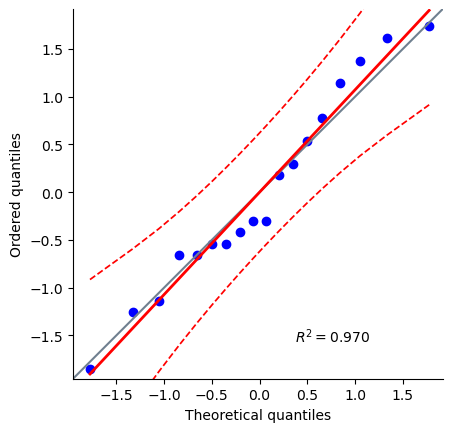

In [25]:
# QQ plot
ax = pg.qqplot(res, dist='norm')
sns.despine()

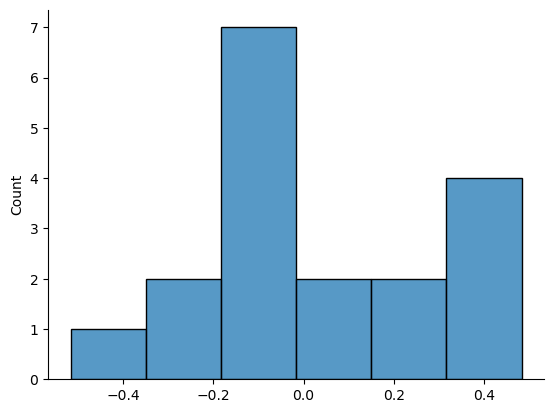

In [26]:
# histogram of residuals

import seaborn as sns


ax = sns.histplot(res)
sns.despine()

In [27]:
#Shapiro-Wilk test with Pingouin

pg.normality(res)

,W,pval,normal
0,0.96019,0.605309,True


In [28]:
#Shapiro-Wilk test with scipy

from scipy.stats import shapiro

shapiro(res)

ShapiroResult(statistic=0.9601902365684509, pvalue=0.6053088307380676)


The histogram and QQ plot are both look pretty normal to me. Not perfect, of course. The histogram in particuar you might need to squint at a bit, to see a normal distringution. But the results of our Shapiro-Wilk test ($W = .96$, $p = .61$) finds no indication that normality is violated, so even if these residuals are not _perfectly_ normally distributed, they seem to be well within the range of the acceptable.

(kruskalwallis)=
## Removing the normality assumption

Now that we've seen how to check for normality, we are led naturally to ask what we can do to address violations of normality. In the context of a one-way ANOVA, the easiest solution is probably to switch to a non-parametric test (i.e., one that doesn't rely on any particular assumption about the kind of distribution involved). We've seen non-parametric tests [before](wilcox): when you only have two groups, the Wilcoxon test provides the non-parametric alternative that you need. When you've got three or more groups, you can use the **_Kruskal-Wallis rank sum test_** {cite}`KruskalWallis1952`. So that's the test we'll talk about next.

### The logic behind the Kruskal-Wallis test

The Kruskal-Wallis test is surprisingly similar to ANOVA, in some ways. In ANOVA, we started with $Y_{ik}$, the value of the outcome variable for the $i$th person in the $k$th group. For the Kruskal-Wallis test, what we'll do is rank order all of these $Y_{ik}$ values, and conduct our analysis on the ranked data. So let's let $R_{ik}$ refer to the ranking given to the $i$th member of the $k$th group. Now, let's calculate $\bar{R}_k$, the average rank given to observations in the $k$th group:

$$
\bar{R}_k = \frac{1}{N_K} \sum_{i} R_{ik}
$$
and let's also calculate $\bar{R}$, the grand mean rank:
$$
\bar{R} = \frac{1}{N} \sum_{i} \sum_{k} R_{ik}
$$

Now that we've done this, we can calculate the squared deviations from the grand mean rank $\bar{R}$. When we do this for the individual scores -- i.e., if we calculate $(R_{ik} - \bar{R})^2$ -- what we have is a "nonparametric" measure of how far the $ik$-th observation deviates from the grand mean rank. When we calculate the squared deviation of the group means from the grand means -- i.e., if we calculate $(\bar{R}_k  - \bar{R} )^2$ -- then what we have is a nonparametric measure of how much the *group* deviates from the grand mean rank. With this in mind, let's follow the same logic that we did with ANOVA, and define our *ranked* sums of squares measures in much the same way that we did earlier. First, we have our "total ranked sums of squares":

$$
\mbox{RSS}_{tot} = \sum_k \sum_i ( R_{ik} - \bar{R} )^2
$$

and we can define the "between groups ranked sums of squares" like this:

$$
\begin{array}{rcl}
\mbox{RSS}_{b} &=& \sum_k \sum_i ( \bar{R}_k  - \bar{R} )^2 \\
&=& \sum_k N_k ( \bar{R}_k  - \bar{R} )^2 
\end{array}
$$

So, if the null hypothesis is true and there are no true group differences at all, you'd expect the between group rank sums $\mbox{RSS}_{b}$ to be very small, much smaller than the total rank sums $\mbox{RSS}_{tot}$. Qualitatively this is very much the same as what we found when we went about constructing the ANOVA $F$-statistic; but for technical reasons the Kruskal-Wallis test statistic, usually denoted $K$, is constructed in a slightly different way: 

$$
K = (N - 1) \times \frac{\mbox{RSS}_b}{\mbox{RSS}_{tot}}
$$

and, if the null hypothesis is true, then the sampling distribution of $K$ is *approximately* chi-square with $G-1$ degrees of freedom (where $G$ is the number of groups). The larger the value of $K$, the less consistent the data are with null hypothesis, so this is a one-sided test: we reject $H_0$ when $K$ is sufficiently large.

### Additional details

The description in the previous section illustrates the logic behind the Kruskal-Wallis test. At a conceptual level, this is the right way to think about how the test works. However, from a purely mathematical perspective it's needlessly complicated. I won't show you the derivation, but you can use a bit of algebraic jiggery-pokery[^notejig] to show that the equation for $K$ can be rewritten as 

$$
K = \frac{12}{N(N-1)} \sum_k N_k {\bar{R}_k}^2    -  3(N+1)
$$

It's this last equation that you sometimes see given for $K$. This is way easier to calculate than the version I described in the previous section, it's just that it's totally meaningless to actual humans. It's probably best to think of $K$ the way I described it earlier... as an analogue of ANOVA based on ranks. But keep in mind that the test statistic that gets calculated ends up with a rather different look to it than the one we used for our original ANOVA.

But wait, there's more! Dear lord, why is there always *more*? The story I've told so far is only actually true when there are no ties in the raw data. That is, if there are no two observations that have exactly the same value. If there *are* ties, then we have to introduce a correction factor to these calculations. At this point I'm assuming that even the most diligent reader has stopped caring (or at least formed the opinion that the tie-correction factor is something that doesn't require their immediate attention). So I'll very quickly tell you how it's calculated, and omit the tedious details about *why* it's done this way. Suppose we construct a frequency table for the raw data, and let $f_j$ be the number of observations that have the $j$-th unique value. This might sound a bit abstract, so here's the Python code showing a concrete example:

In [29]:
# Make a frequency table of the counts of unique values (mood gain)

f = df['mood_gain'].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values('unique_values')
f

,unique_values,counts
5,0.1,1
7,0.2,1
0,0.3,2
6,0.4,1
4,0.5,1
1,0.6,2
11,0.8,1
9,0.9,1
10,1.1,1
12,1.2,1


Looking at these frequencies, notice that the third entry in the frequency table has a value of $2$. Since this corresponds to a `mood_gain` of 0.3, this table is telling us that two people's mood increased by 0.3. More to the point, note that we can say that `f['counts'][2]` has a value of `2`. Or, in the mathematical notation I introduced above, this is telling us that $f_3 = 2$. Yay. So, now that we know this, the tie correction factor (TCF) is:

$$
\mbox{TCF} = 1 - \frac{\sum_j {f_j}^3 - f_j}{N^3 - N} 
$$

The tie-corrected value of the Kruskal-Wallis statistic obtained by dividing the value of $K$ by this quantity: it is this tie-corrected version that Python calculates. And at long last, we're actually finished with the theory of the Kruskal-Wallis test. I'm sure you're all terribly relieved that I've cured you of the existential anxiety that naturally arises when you realise that you *don't* know how to calculate the tie-correction factor for the Kruskal-Wallis test. Right?


[^notejig]: A technical term.

### How to run the Kruskal-Wallis test in Python

Despite the horror that we've gone through in trying to understand what the Kruskal-Wallis test actually does, it turns out that running the test is pretty painless, since `pingouin` has a function called `kruskal()`:

In [30]:
import pingouin as pg

pg.kruskal(data=df, 
        dv='mood_gain', 
        between='drug').round(3)

,Source,ddof1,H,p-unc
Kruskal,drug,2,12.076,0.002


(anovaandt)=

## On the relationship between ANOVA and the Student $t$ test

There's one last thing I want to point out before finishing. It's something that a lot of people find kind of surprising, but it's worth knowing about: an ANOVA with two groups is identical to the Student $t$-test. No, really. It's not just that they are similar, but they are actually equivalent in every meaningful way. I won't try to prove that this is always true, but I will show you a single concrete demonstration. Suppose that, instead of running an ANOVA on our `mood_gain` predicted by `drug` model, let's instead do it using `therapy` as the predictor. If we run this ANOVA, here's what we get`


In [31]:
import pingouin as pg
pg.anova(dv='mood_gain', 
         between='therapy', 
         data=df).round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,therapy,1,16,1.708,0.21,0.096


Overall, it looks like there's no significant effect here at all but, as we'll [soon see](anova2) this is actually a misleading  answer! In any case, it's irrelevant to our current goals: our interest here is in the $F$-statistic, which is $F(1,16) = 1.71$, and the $p$-value, which is .21. Since we only have two groups, I didn't actually need to resort to an ANOVA, I could have just decided to run a Student $t$-test. So let's see what happens when I do that. First, I'll just re-arrange the data in to wide format:

In [32]:
df_wide = pd.DataFrame(
                {'no_therapy': df.loc[df['therapy'] == 'no.therapy']['mood_gain'],
                 'CBT': df.loc[df['therapy'] == 'CBT']['mood_gain']})


Then we can run the test

In [33]:
import pingouin as pg

pg.ttest(df_wide['no_therapy'], 
         df_wide['CBT']).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.307,16,two-sided,0.21,"[-0.84, 0.2]",0.616,0.732,0.233


Curiously, the $p$-values are identical: once again we obtain a value of $p = .21$. But what about the test statistic? Having run a $t$-test instead of an ANOVA, we get a somewhat different answer, namely $t(16) = -1.3068$. However, there is a fairly straightforward relationship here. If we square the $t$-statistic

In [34]:
round((-1.307)**2,3)

1.708


we get the $F$-statistic from before. Kinda cool, innit?

## Summary

There's a fair bit covered in this chapter, but there's still a lot missing. Most obviously, I haven't yet discussed any analog of the paired samples $t$-test for more than two groups. There is a way of doing this, known as *repeated measures ANOVA*, which I am happy to report, ``pingouin`` [handles](https://pingouin-stats.org/build/html/generated/pingouin.rm_anova.html#pingouin.rm_anova) with [aplomb](https://en.wikipedia.org/wiki/Aplomb). I also haven't discussed how to run an ANOVA when you are interested in more than one grouping variable, but that will be discussed in a lot of detail in a [later chapter](anova2). In terms of what we have discussed, the key topics were:


- The basic logic behind [how ANOVA works](anovaintro) and [how to run one in Python](introduceaov).
- How to compute an [effect size for an ANOVA](etasquared).
- [Post hoc analysis and corrections for multiple testing](posthoc).
- The [assumptions](anovaassumptions) made by ANOVA.
- [How to check the homogeneity of variance assumption](levene) and [what to do](welchoneway) if it is violated.
- [How to check the normality assumption](anovanormality) and [what to do](kruskalwallis) if it is violated.


As with all of the chapters in this book, there are quite a few different sources that I've relied upon, but the one stand-out text that I've been most heavily influenced by is {cite}`Sahai2000`. It's not a good book for beginners, but it's an excellent book for more advanced readers who are interested in understanding the mathematics behind ANOVA.

[^note1]: When all groups have the same number of observations, the experimental design is said to be "balanced". Balance isn't such a big deal for one-way ANOVA, which is the topic of this chapter. It becomes more important when you start doing more complicated ANOVAs.

[^note2]: In a later versions I'm intending to expand on this. But because I'm writing in a rush, and am already over my deadlines, I'll just briefly note that if you read ahead to the chapter on [factorial anovas](anova2) and look at how the "treatment effect" at level $k$ of a factor is defined in terms of the $\alpha_k$ values (check out the section on [interactions](interactions)), it turns out that $Q$ refers to a weighted mean of the squared treatment effects, $Q=(\sum_{k=1}^G N_k\alpha_k^2)/(G-1)$.

[^note3]: Or, if we want to be sticklers for accuracy, $1 + \frac{2}{df_2 - 2}$.

[^note4]: Or, to be precise, party like "it's 1899 and we've got no friends and nothing better to do with our time than do some calculations that wouldn't have made any sense in 1899 because ANOVA didn't exist until about the 1920s".

[^plannedcomparisons]: If you *do* have some theoretical basis for wanting to investigate some comparisons but not others, it's a different story. In those circumstances you're not really running "post hoc" analyses at all: you're making "planned comparisons". I do talk about this situation [later in the book](plannedcomparisons)), but for now I want to keep things simple.

[^bonf]: It's worth noting in passing that not all adjustment methods try to do this. What I've described here is an approach for controlling "family wise Type I error rate". However, there are other post hoc tests seek to control the "false discovery rate", which is a somewhat different thing.